# Diamond Price Prediction Model

## Project Overview

The Diamond Price Prediction project aims to build a machine learning model that accurately estimates the price of a diamond based on its attributes such as carat, cut, color, clarity, depth, and dimensions. The project will involve data collection, preprocessing, feature engineering, model training, and deployment through a Streamlit web application.

Link to Dataset: https://www.kaggle.com/datasets/willianoliveiragibin/type-of-the-diamond

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

import kagglehub
import os

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_validate, KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go
import plotly.express as px
from plotly.io import show
from dash import Dash, html, dcc, Input, Output
import dash_bootstrap_components as dbc

import optuna



/opt/anaconda3/envs/SDSenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Ingestion

In [2]:
# Download latest version
path = kagglehub.dataset_download("willianoliveiragibin/type-of-the-diamond")

print("Path to dataset files:", path)

Path to dataset files: /Users/reema14a/.cache/kagglehub/datasets/willianoliveiragibin/type-of-the-diamond/versions/1


In [3]:
dataset = pd.read_csv(path + '/' + os.listdir(path)[0])

In [4]:
dataset.shape

(53940, 10)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cut            53940 non-null  object 
 1   color          53940 non-null  object 
 2   clarity        53940 non-null  object 
 3   carat          53940 non-null  float64
 4   depth          53940 non-null  float64
 5   table          53940 non-null  float64
 6   price          53940 non-null  int64  
 7   x (Premium)    53940 non-null  float64
 8   z (Very Good)  53940 non-null  float64
 9   y (Good)       53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


*   **carat**: indicates the weight of the diamond 
*   **cut**: determines its shine with categories such as `ideal`, `premium`, `good`, `very good` and `fair`  
*   **color**: ranges from `D` to `J` affecting the visual appeal of the diamond 
*   **clarity**: describes the internal purity of the diamond with classifications like `SI2`, `SI1`, `VS1`, `VS2`, `VVS2`, `VVS1` and `I1` 
*   **depth**: represents the diamond’s depth percentage 
*   **table**: refers to the flat facet on its surface which is the large flat area visible from above 
*   **x**: denotes the width of the diamond 
*   **y**: denotes the length of the diamond 
*   **z**: denotes the height of the diamond 
*   **price**: indicates the cost of the diamond in USD

In [6]:
dataset.head(5)

,cut,color,clarity,carat,depth,table,price,x (Premium),z (Very Good),y (Good)
0,Fair,E,VS2,0.22,65.1,61.0,337,3.87,2.49,3.78
1,Fair,E,SI2,0.86,55.1,69.0,2757,6.45,3.52,6.33
2,Fair,F,SI2,0.96,66.3,62.0,2759,6.27,4.07,5.95
3,Fair,F,VS2,0.70,64.5,57.0,2762,5.57,3.58,5.53
4,Fair,F,VS2,0.70,65.3,55.0,2762,5.63,3.66,5.58


## EDA

In [7]:
# Check for null values
dataset.isnull().sum()

cut              0
color            0
clarity          0
carat            0
depth            0
table            0
price            0
x (Premium)      0
z (Very Good)    0
y (Good)         0
dtype: int64

***No null* values**

### Rename columns

In [8]:
dataset.rename(columns = {'x (Premium)': 'x',
                          'y (Good)': 'y',
                          'z (Very Good)': 'z'},
                inplace = True)

### Univariate Analysis

In [9]:
categorical_features = ['cut', 'color', 'clarity']
numerical_features = dataset.select_dtypes(include=[np.number]).columns 

In [10]:
for x in categorical_features:
    print('-----------------')
    print('\033[1m' + x + '\033[0m')
    print('-----------------')
    print(dataset[x].value_counts())

-----------------
cut
-----------------
cut
Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: count, dtype: int64
-----------------
color
-----------------
color
G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: count, dtype: int64
-----------------
clarity
-----------------
clarity
SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: count, dtype: int64


In [11]:
sns.set_theme(context = 'paper', style = 'dark')
sns.set_palette('husl', 10)

### Price Distribution

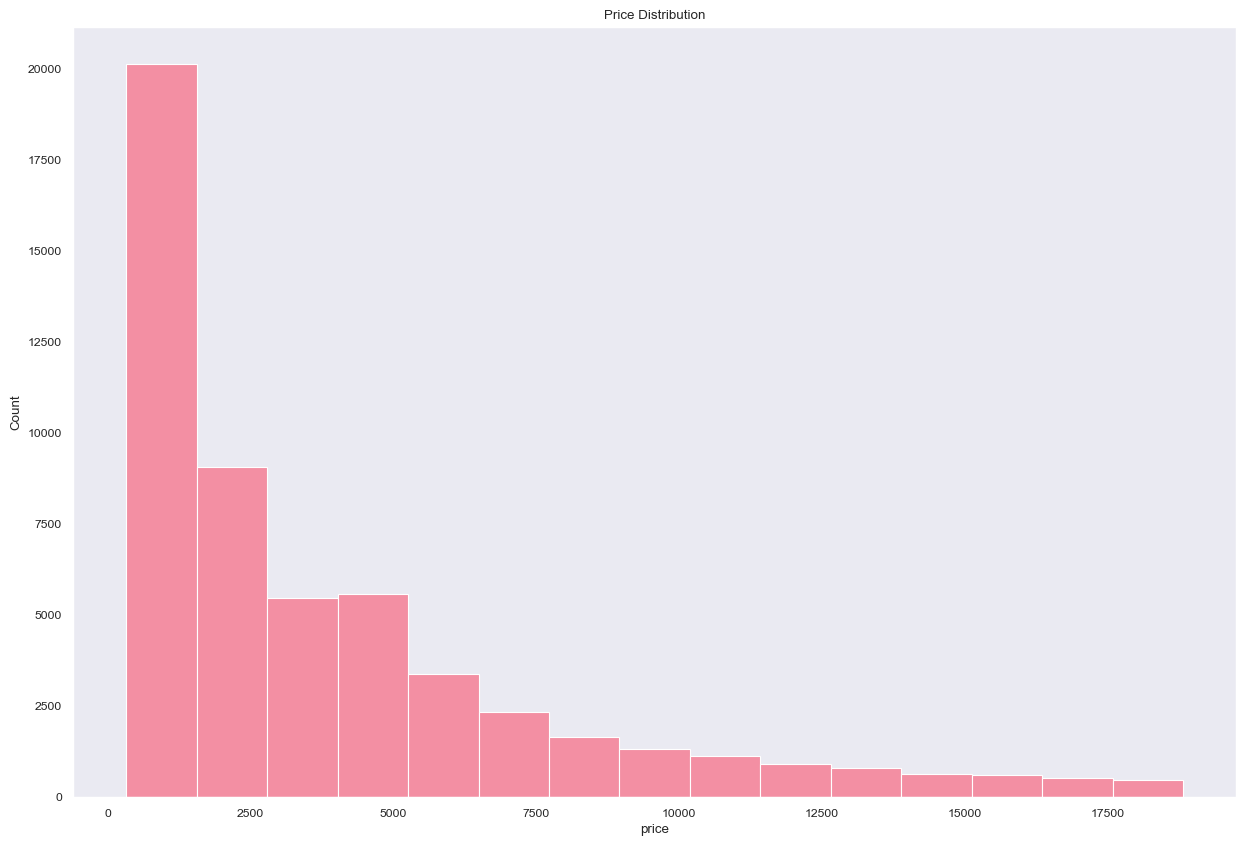

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(data = dataset, x = 'price', bins = 15)
plt.title('Price Distribution')
plt.show()

### Distribution of Categorical Features

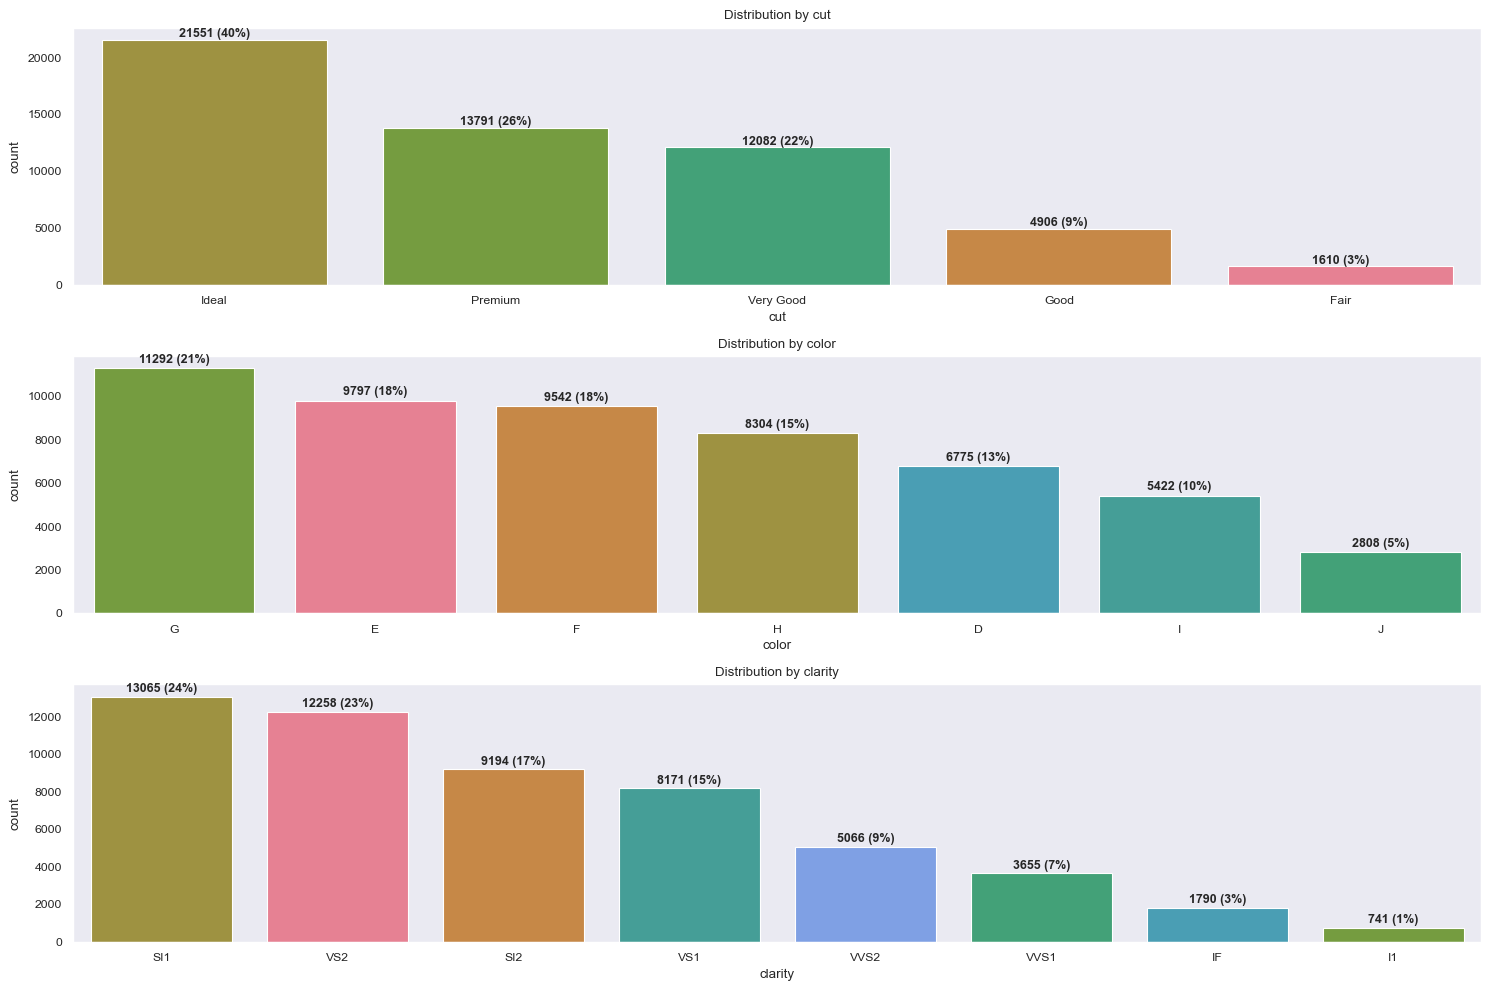

In [13]:
plt.figure(figsize=(15,10))

for index, feature in enumerate(categorical_features):
    abs_values = dataset[feature].value_counts(ascending=False)
    rel_values = dataset[feature].value_counts(ascending=False, normalize=True).values * 100
    lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]


    plt.subplot(3, 1, index + 1)
    ax = sns.countplot(data = dataset, 
                    x = feature, 
                    order=abs_values.index,
                    hue = feature, 
                    )

    # Extract bars in sorted order
    bars = sorted(ax.patches, key=lambda bar: bar.get_x())  # Sort bars by x-position

    # Annotate each bar with corresponding label
    for bar, lbl in zip(bars, lbls):  
        ax.text(bar.get_x() + bar.get_width()/2,  # X-coordinate (center of bar)
                bar.get_height() + 250,            # Y-coordinate (above bar)
                lbl,                              # Label text
                ha='center',                      # Center alignment
                fontsize=9, 
                fontweight='bold')
    
    plt.title('Distribution by ' + feature)
plt.tight_layout()
plt.show()

### Distribution of Numerical Features

In [14]:
dataset.describe()

,carat,depth,table,price,x,z,y
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,3.538734,5.734526
std,0.474011,1.432621,2.234491,3989.439738,1.121761,0.705699,1.142135
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,2.910000,4.720000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,3.530000,5.710000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,4.040000,6.540000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,31.800000,58.900000


### Bivariate Analysis

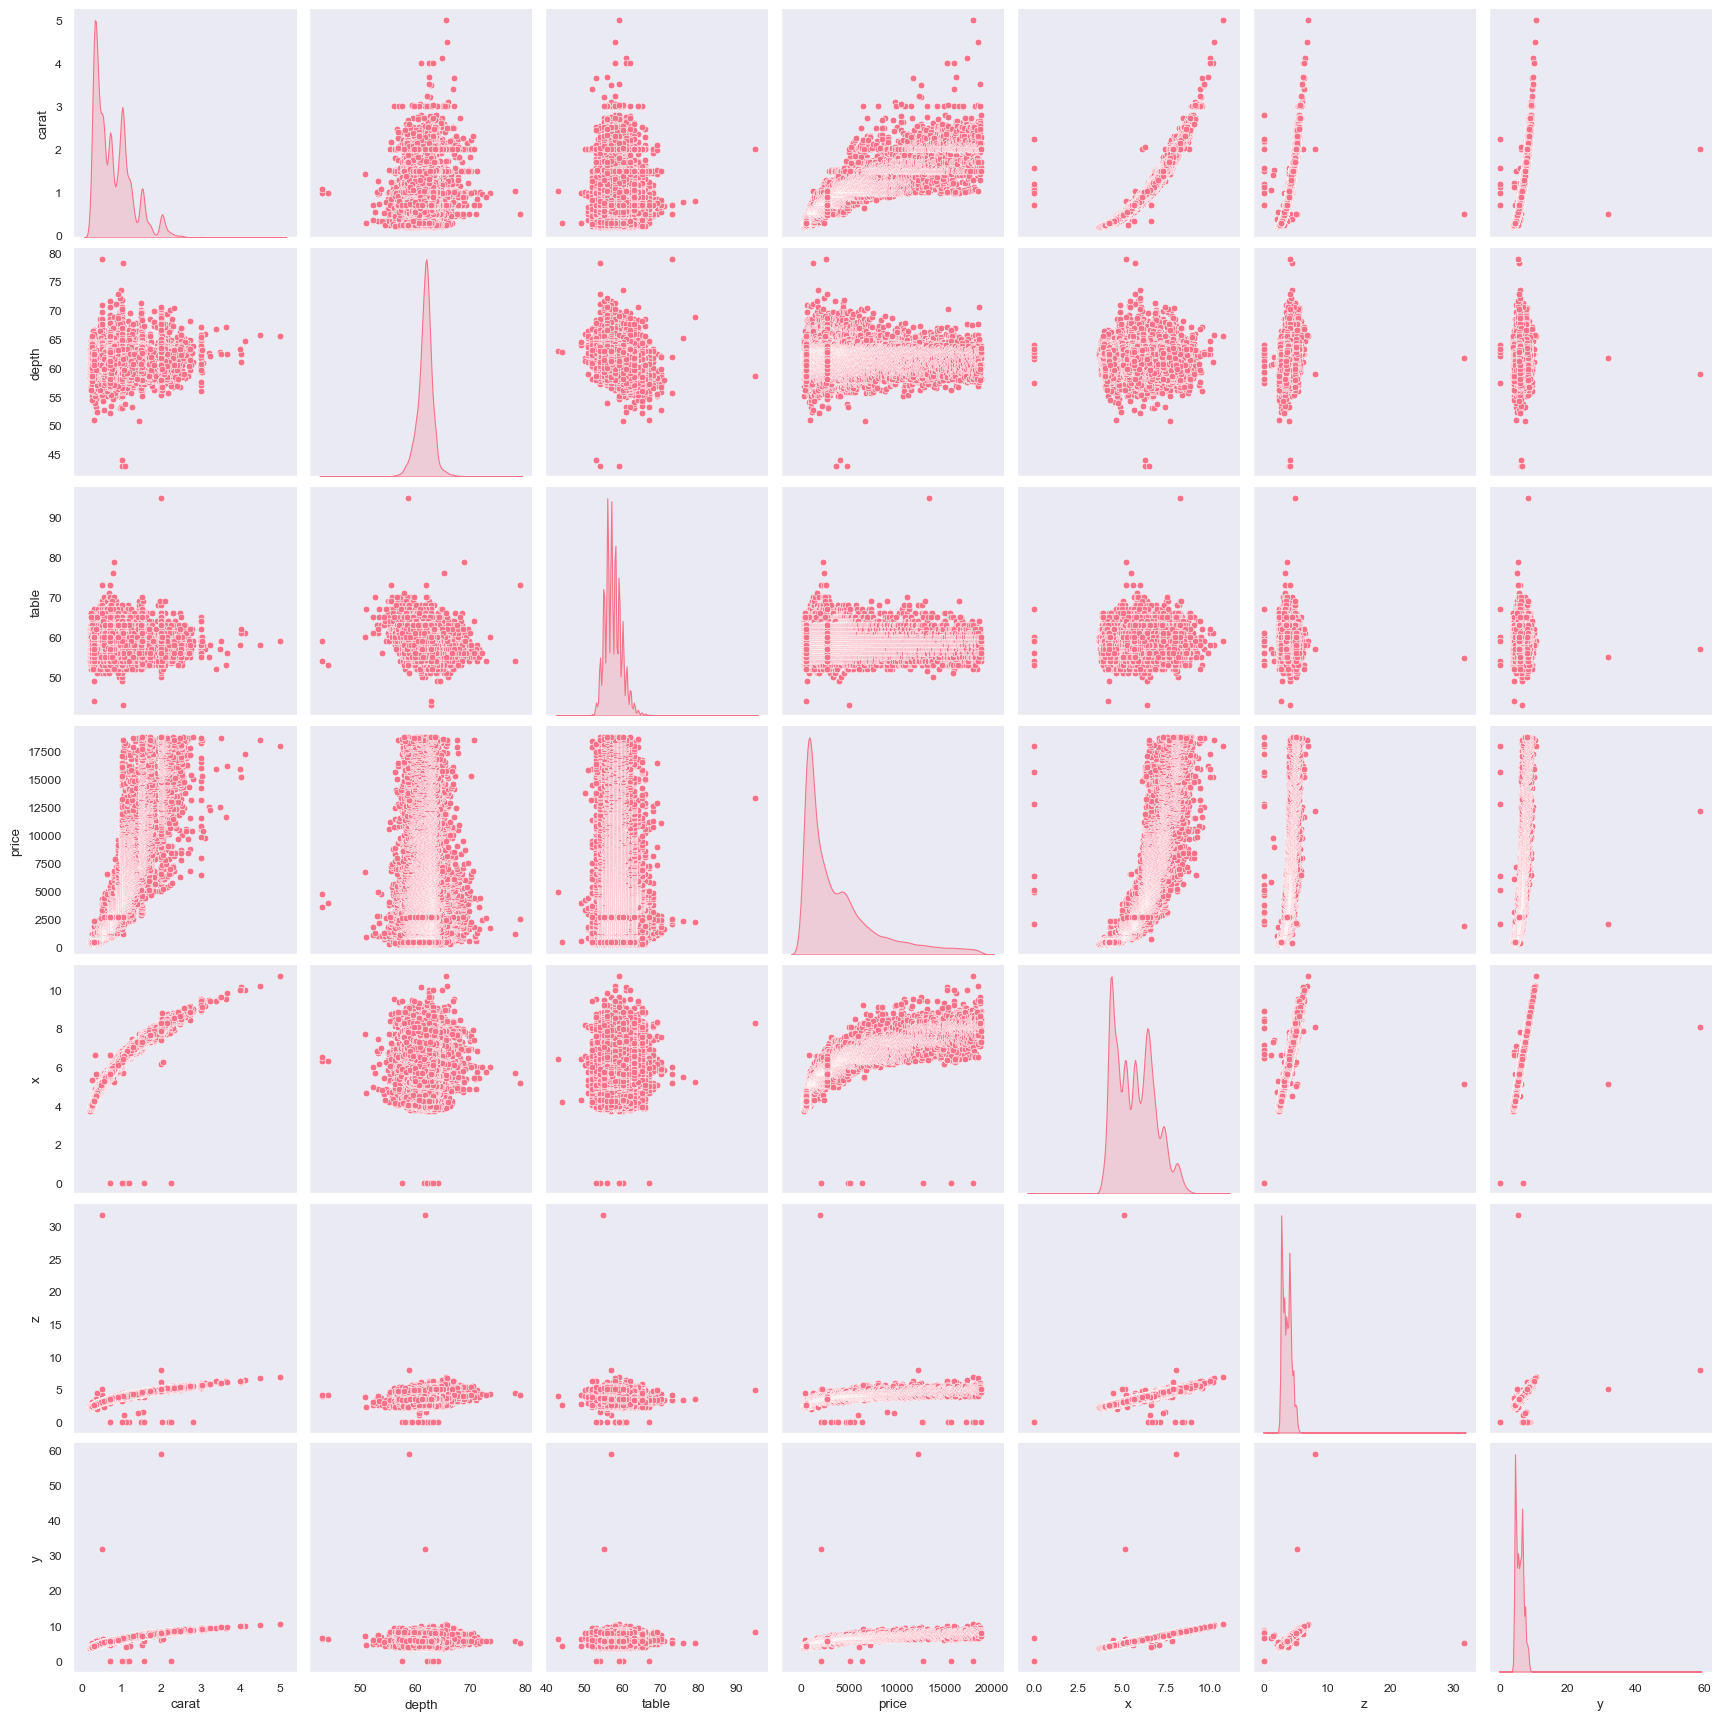

In [15]:
sns.pairplot(dataset[numerical_features], diag_kind='kde')
plt.show()

In [16]:
large_diamond = dataset['carat'].gt(dataset['carat'].quantile(0.75)).rename('large_diamond')

### **Cut - Best to Worst**
**Ideal -> Premium -> Very Good -> Good -> Fair**

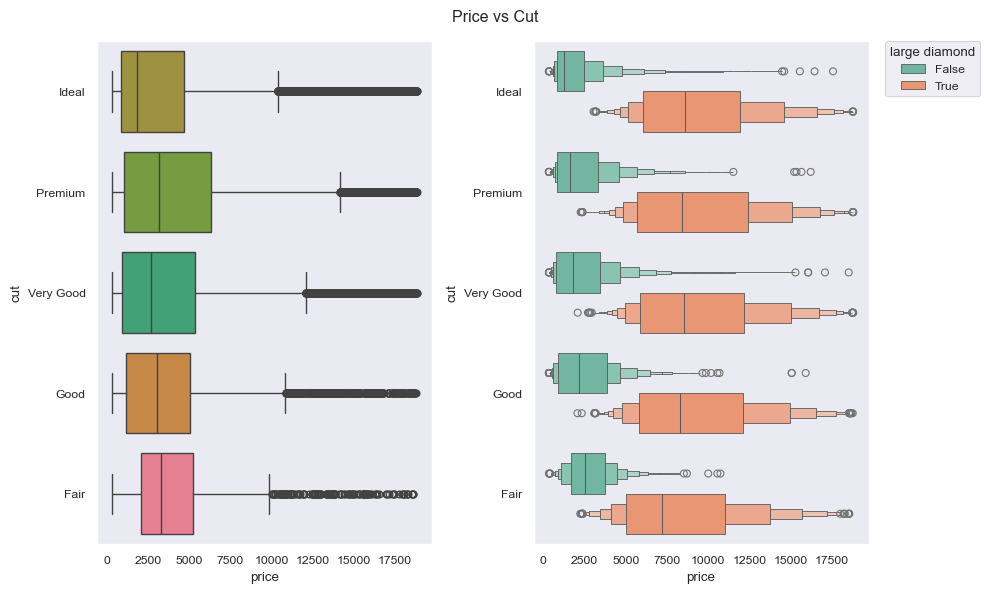

In [17]:
cut_order = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(data = dataset, x = 'price', y = 'cut', order = cut_order, hue = 'cut')

plt.subplot(1,2,2)
sns.boxenplot(data=dataset, x='price', y='cut', order = cut_order, legend='auto', hue = large_diamond, palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., title = 'large diamond')

plt.suptitle('Price vs Cut')
plt.tight_layout()
plt.show()

**Key Observations**
*   Higher cut quality does not always mean a higher price
*   Larger diamonds with any cut grade are more expensive than smaller, higher-quality diamonds

### **Clarity - Best to Worst**
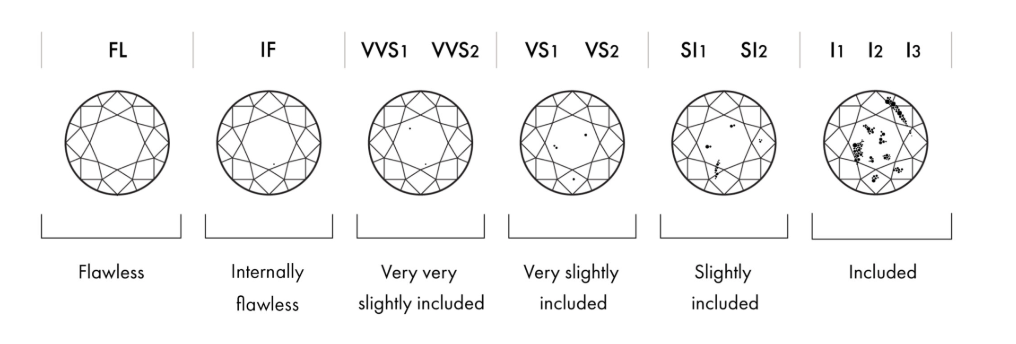

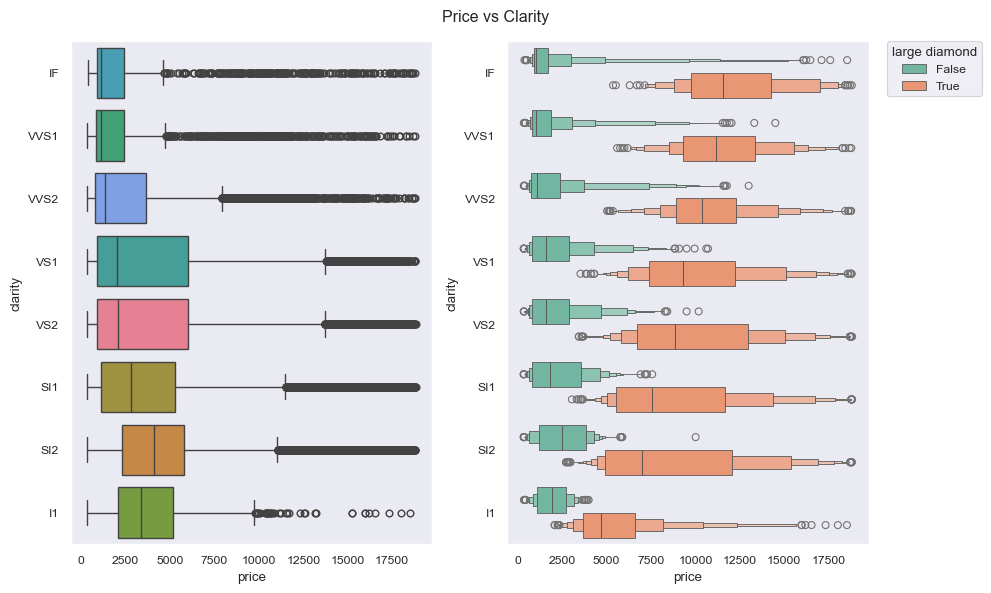

In [18]:
clarity_order = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(data=dataset, x='price', y='clarity', order = clarity_order, hue = 'clarity')

plt.subplot(1,2,2)
sns.boxenplot(data=dataset, x='price', y='clarity', order = clarity_order, legend='auto', hue = large_diamond, palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., title = 'large diamond')

plt.suptitle('Price vs Clarity')
plt.tight_layout()
plt.show()

**Key Observations**
*   Clarity impacts price but is not the strongest factor
*   Large diamonds with lower clarity can still be more expensive than small, high-clarity diamonds

### **Color - Best to Worst**
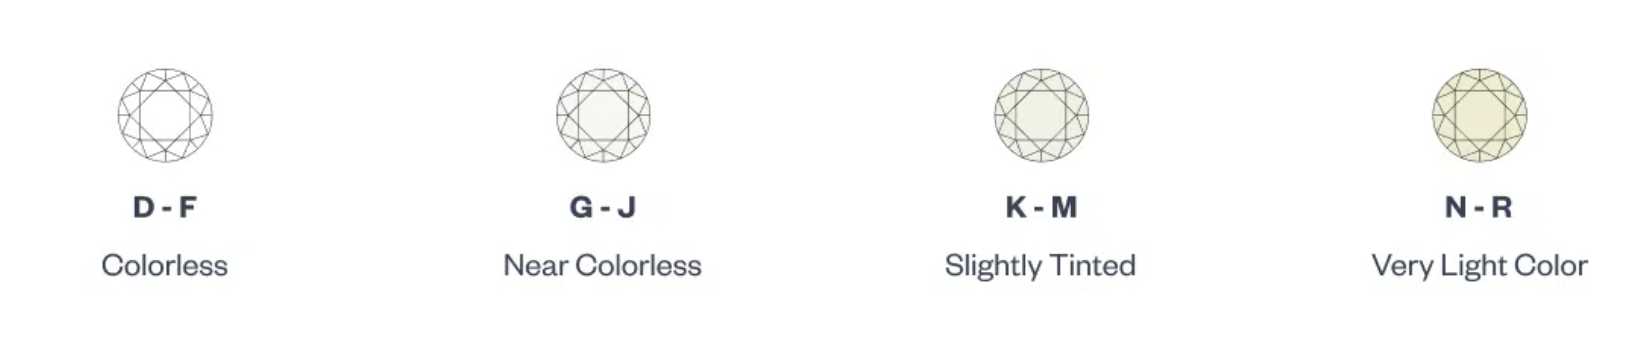

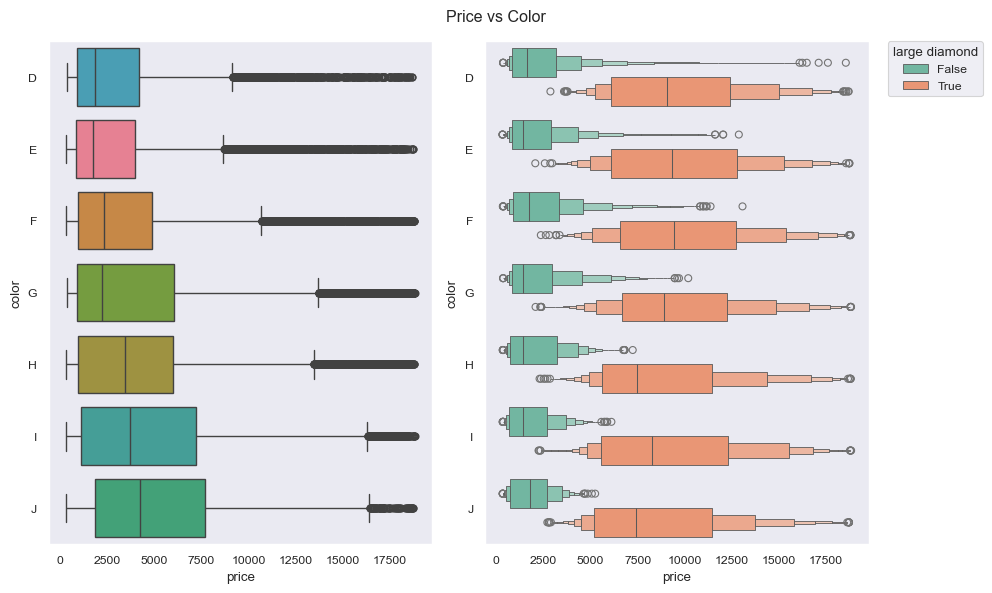

In [19]:
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
sns.boxplot(data=dataset, x='price', y='color', order = color_order, hue = 'color')

plt.subplot(1,2,2)
sns.boxenplot(data=dataset, x='price', y='color', order = color_order, legend='auto', hue = large_diamond, palette = 'Set2')
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0., title = 'large diamond')

plt.suptitle('Price vs Color')
plt.tight_layout()
plt.show()

**Key Observations**
*   Color alone does not determine price
*   Large diamonds significantly drive up prices across all color grades.

### Visualization of Price against all numerical features wrt Categorical Features and OLS Trendline

In [20]:
y_variables = ['price']
x_variables = numerical_features.tolist()
x_variables.remove('price')
col_variables = categorical_features
scope_values = ['overall', 'trace']


In [21]:
dataset

,cut,color,clarity,carat,depth,table,price,x,z,y
0,Fair,E,VS2,0.22,65.1,61.0,337,3.87,2.49,3.78
1,Fair,E,SI2,0.86,55.1,69.0,2757,6.45,3.52,6.33
2,Fair,F,SI2,0.96,66.3,62.0,2759,6.27,4.07,5.95
3,Fair,F,VS2,0.70,64.5,57.0,2762,5.57,3.58,5.53
4,Fair,F,VS2,0.70,65.3,55.0,2762,5.63,3.66,5.58
...,...,...,...,...,...,...,...,...,...,...
53935,Very Good,E,VS2,0.70,62.8,60.0,2755,5.59,3.53,5.65
53936,Very Good,D,VS1,0.70,63.1,59.0,2755,5.67,3.55,5.58
53937,Very Good,E,VS2,0.70,60.5,59.0,2757,5.71,3.47,5.76
53938,Very Good,E,VS2,0.70,61.2,59.0,2757,5.69,3.49,5.72


In [22]:
df = dataset.copy(deep=True)

In [23]:
# Plotly Visualization for dynamic graph

app = Dash(__name__, external_stylesheets=[dbc.themes.CERULEAN])

app.layout = dbc.Container(
    [
        dbc.Row(
            [
                dbc.Col(
                    [
                        dcc.Markdown(
                            "#### Plotly Express line chart with trendlines and dropdown",
                            className="text-white",

                        )
                    ],  # style={"textalign": "center"},
                    width=8
                )
            ],
            className="bg-secondary rounded-3 mt-2",
            # style={"textalign": "center"},

            justify="center"

        ),
        dbc.Row(

            [

                dbc.Col([dbc.Label(
                            "Target variable:",
                            # className="bg-info bg-opacity-50 mt-2 p-2",
                            className="mt-2 p-2",
                            style={"width": "100%"},
                        ),
                            dcc.Dropdown(y_variables,
                                        y_variables[0], id='y_val'),
                            dbc.Label(
                                "Explanatory variable:",
                                # className="bg-info bg-opacity-50 mt-2 p-2",
                                className="mt-2 p-2",
                                style={"width": "100%"},
                            ),
                            dcc.Dropdown(x_variables,
                                        x_variables[0], id='x_val'),
                            dbc.Label(
                                "Distribution variable:",
                                # className="bg-info bg-opacity-50 mt-2 p-2",
                                className="mt-2 p-2",
                                style={"width": "100%"},
                            ),
                            dcc.Dropdown(col_variables,
                                        col_variables[0], id='col_val'),
                            dbc.Label(
                                "Trendline Scope:",
                                # className="bg-info bg-opacity-50 mt-2 p-2",
                                className="mt-2 p-2",
                                style={"width": "100%"},
                            ),
                            dcc.Dropdown(scope_values,
                                        scope_values[0], id='scope_val'),

                    ], 
                        width=4
                ),
                dbc.Col(
                    [

                        dcc.Graph(id='fig1')
                    ]
                )
            ],
            className="bg-secondary bg-opacity-25 rounded-3 p-2 mt-2",
        ),
    ]
)


@ app.callback(Output('fig1', 'figure'),
               [Input('y_val', 'value'),
                Input('x_val', 'value'),
                Input('col_val', 'value'),
                Input('scope_val', 'value'),
                ])
def trends(y, x, col, scope):

    fig = px.scatter(df, x=x, y=y, color=col, trendline="ols", trendline_scope=scope)
    fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)')
    return fig

app.run(debug=True, use_reloader=False, mode='inline')

### Ordinal Encoding

Since using Random Forest, XGBoost → Label Encoding is better. \
If using Linear Regression, SVM → One-Hot Encoding is better. \
However, since we have order in the categories, manually defining mapping to set correct order.

In [24]:
#Using OrdinalEncoding to convert 
categories_order = [cut_order, color_order, clarity_order]

for feature, order in zip(categorical_features, categories_order):
    print(f"Feature: {feature}")
    print(f"Category Order: {order}")
    #print(f"Category Order: {order.reverse}")
    oe = OrdinalEncoder(categories = [order])
    dataset[feature + '_en'] = oe.fit_transform(dataset[[feature]])     

Feature: cut
Category Order: ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']
Feature: color
Category Order: ['D', 'E', 'F', 'G', 'H', 'I', 'J']
Feature: clarity
Category Order: ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']


In [25]:
dataset

,cut,color,clarity,carat,depth,table,price,x,z,y,cut_en,color_en,clarity_en
0,Fair,E,VS2,0.22,65.1,61.0,337,3.87,2.49,3.78,4.0,1.0,4.0
1,Fair,E,SI2,0.86,55.1,69.0,2757,6.45,3.52,6.33,4.0,1.0,6.0
2,Fair,F,SI2,0.96,66.3,62.0,2759,6.27,4.07,5.95,4.0,2.0,6.0
3,Fair,F,VS2,0.70,64.5,57.0,2762,5.57,3.58,5.53,4.0,2.0,4.0
4,Fair,F,VS2,0.70,65.3,55.0,2762,5.63,3.66,5.58,4.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,Very Good,E,VS2,0.70,62.8,60.0,2755,5.59,3.53,5.65,2.0,1.0,4.0
53936,Very Good,D,VS1,0.70,63.1,59.0,2755,5.67,3.55,5.58,2.0,0.0,3.0
53937,Very Good,E,VS2,0.70,60.5,59.0,2757,5.71,3.47,5.76,2.0,1.0,4.0
53938,Very Good,E,VS2,0.70,61.2,59.0,2757,5.69,3.49,5.72,2.0,1.0,4.0


In [26]:
# Dropping original categorical columns as we have the encoded values now
dataset.drop(columns= ['cut', 'color', 'clarity'], inplace = True)

Text(0.5, 1.0, 'Feature Correlation Heatmap')

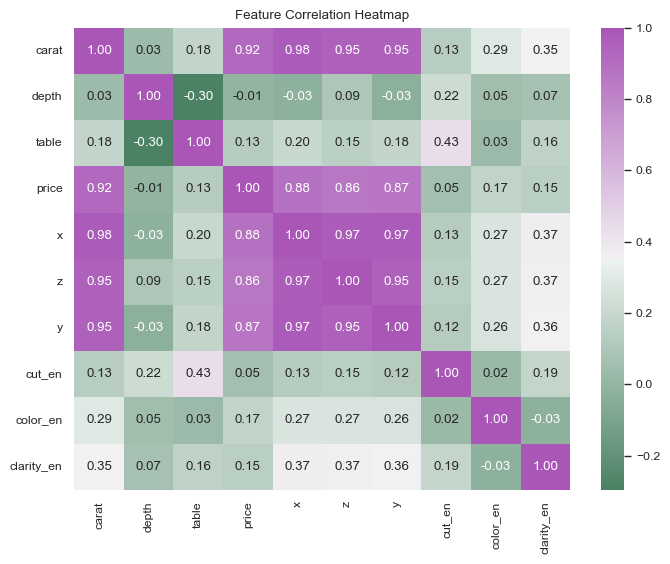

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(dataset.corr(), annot=True, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
, fmt='.2f')
plt.title('Feature Correlation Heatmap')

**Key Observations**
*   Carat is the most important factor in determining diamond price
*   Physical size (x, y, z) has a strong influence on price
*   Cut, color, and clarity play a much smaller role in price variation
*   Depth and table have little to no impact on price

### Outliers

In [28]:
outliers = pd.DataFrame()

for feature in numerical_features:
    Q1 = dataset[feature].quantile(0.25)
    Q3 = dataset[feature].quantile(0.75)


    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask = (dataset[feature] < lower_bound) | (dataset[feature] > upper_bound)
    outliers = pd.concat([outliers, dataset[feature][mask]], axis = 1)

In [29]:
outliers.head()

,carat,depth,table,price,x,z,y
604,2.14,69.4,NaN,NaN,NaN,NaN,NaN
606,2.15,65.5,NaN,NaN,NaN,NaN,NaN
625,2.22,66.7,NaN,NaN,NaN,NaN,NaN
637,2.01,67.4,NaN,NaN,NaN,NaN,NaN
638,2.01,55.9,64.0,NaN,NaN,NaN,NaN


In [30]:
print("Percentage of outliers")
print("----------------------")
outliers.count() / len(dataset) * 100

Percentage of outliers
----------------------


carat    3.502039
depth    4.718205
table    1.121617
price    6.562848
x        0.059325
z        0.090842
y        0.053763
dtype: float64

**Outliers have been retained for now. \
Their removal will be considered based on model selection and performance evaluation.**

## Model Development

In [31]:
X = dataset.drop('price', axis = 1)
y = dataset['price']

In [32]:
X

,carat,depth,table,x,z,y,cut_en,color_en,clarity_en
0,0.22,65.1,61.0,3.87,2.49,3.78,4.0,1.0,4.0
1,0.86,55.1,69.0,6.45,3.52,6.33,4.0,1.0,6.0
2,0.96,66.3,62.0,6.27,4.07,5.95,4.0,2.0,6.0
3,0.70,64.5,57.0,5.57,3.58,5.53,4.0,2.0,4.0
4,0.70,65.3,55.0,5.63,3.66,5.58,4.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...
53935,0.70,62.8,60.0,5.59,3.53,5.65,2.0,1.0,4.0
53936,0.70,63.1,59.0,5.67,3.55,5.58,2.0,0.0,3.0
53937,0.70,60.5,59.0,5.71,3.47,5.76,2.0,1.0,4.0
53938,0.70,61.2,59.0,5.69,3.49,5.72,2.0,1.0,4.0


In [33]:
X.columns

Index(['carat', 'depth', 'table', 'x', 'z', 'y', 'cut_en', 'color_en',
       'clarity_en'],
      dtype='object')

**Note**: Need to Scale the values since we are going to use KNN Regression model as well. \
Scaling not required for RandomForest and XGBoost

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 10, random_state = 0) # with default parameters


In [35]:
from xgboost import XGBRFRegressor
xgbrf_regressor = XGBRFRegressor(random_state=0) # with default parameters

In [36]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)

In [37]:
models = {'RandomForestRegressor': rf_regressor,
           'XGBRFRegressor': xgbrf_regressor,
           'KNeighborsRegressor': knn_regressor
           
         }

In [ ]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cv_results = pd.DataFrame()
model_feature_imp = pd.DataFrame()

for index, (key, value) in enumerate(models.items()):

    # Define Pipeline: Scaling + Model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scale features within each CV fold
        ('model', value)
    ])

    result = cross_validate(pipeline, X, y, 
                                cv=kf, 
                                scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
                                return_train_score = True,
                                return_estimator = True)
    # print(result)
    # print("Important Features:", result['estimator'][0].feature_importances_)
    # print("Important Features:", type(result['estimator'][0].feature_importances_))
    # print("Model parameters:", result['estimator'][0].get_params())

    cross_val_result = pd.DataFrame(result)
    cross_val_result['Model'] = key 
    cross_val_result.drop('estimator', axis = 1, inplace=True)
    cv_results = pd.concat([cv_results, cross_val_result])

    model_result = result['estimator'][0].named_steps['model']
    # Check if the model has 'feature_importances_' attribute before accessing it
    if hasattr(model_result, "feature_importances_"):
        feature_imp_list = model_result.feature_importances_
        feature_imp_df = pd.DataFrame([feature_imp_list], columns = X.columns)
        feature_imp_df['Model'] = key 
        model_feature_imp = pd.concat([model_feature_imp, feature_imp_df])
    else:
        print(f "⚠️ The model {value} does not have feature_importances_ (e.g., KNN, SVM, etc.)")
    


    

⚠️ The model does not have feature_importances_ (e.g., KNN, SVM, etc.)


**Feature Importance by Model**

In [39]:
model_feature_imp

,carat,depth,table,x,z,y,cut_en,color_en,clarity_en,Model
0,0.539449,0.003179,0.002307,0.004565,0.004567,0.350084,0.001795,0.031615,0.062438,RandomForestRegressor
0,0.572359,0.001808,0.000906,0.099125,0.003975,0.280542,0.001286,0.013941,0.026058,XGBRFRegressor


## Model Evaluation

In [40]:
cv_results


,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error,Model
0,3.771078,0.057598,0.979442,0.996674,-567.300378,-230.282616,-280.950034,-108.702540,RandomForestRegressor
1,4.051854,0.027491,0.977981,0.996577,-584.537329,-233.718429,-290.237122,-109.105166,RandomForestRegressor
2,2.923879,0.046882,0.979244,0.996510,-591.081270,-234.894615,-288.629325,-110.163438,RandomForestRegressor
3,3.640475,0.039633,0.980925,0.996503,-553.968445,-235.764500,-277.271593,-109.802054,RandomForestRegressor
4,3.581738,0.038093,0.980170,0.996545,-564.265543,-234.377082,-282.644707,-109.870865,RandomForestRegressor
5,3.105308,0.027877,0.982160,0.996515,-533.700004,-235.472338,-270.174309,-109.855924,RandomForestRegressor
6,2.747961,0.027924,0.979180,0.996580,-583.034827,-232.966160,-283.996304,-108.985399,RandomForestRegressor
7,3.123697,0.029097,0.978646,0.996658,-570.949491,-231.130412,-273.283518,-109.171252,RandomForestRegressor
8,2.760424,0.040235,0.982250,0.996467,-536.487958,-236.880449,-272.785299,-110.690045,RandomForestRegressor
9,3.271178,0.028550,0.982160,0.996475,-520.425631,-237.470514,-259.977594,-110.390496,RandomForestRegressor


*   **R² (R-squared)**
    *   Measures how well the model explains the variance in the target variable.
    *   Ranges from 0 to 1 (or negative if the model is worse than a constant prediction).
    *   Best when you want an overall goodness-of-fit measure.
    *   *Limitation*: Doesn't directly show how much error the model makes in predicting prices.
*   **RMSE (Root Mean Squared Error)**
    *   Measures the average prediction error in original price units (USD in your case).
    *   Penalizes large errors more than small ones (because of squaring).
    *   Best when large price prediction errors are critical (e.g., for high-value diamonds).
    *   *Limitation*: Sensitive to outliers.
*   **MAE (Mean Absolute Error)**
    *   Measures the average absolute error in original price units (USD).
    *   Treats all errors equally (unlike RMSE).
    *   Best when you want a simple interpretation of average prediction error.
    *   *Limitation*: Doesn't penalize large errors as heavily as RMSE.

In [41]:
models_list = cv_results['Model'].unique().tolist()
len(models_list)

3

**Model Results from Cross Validation**

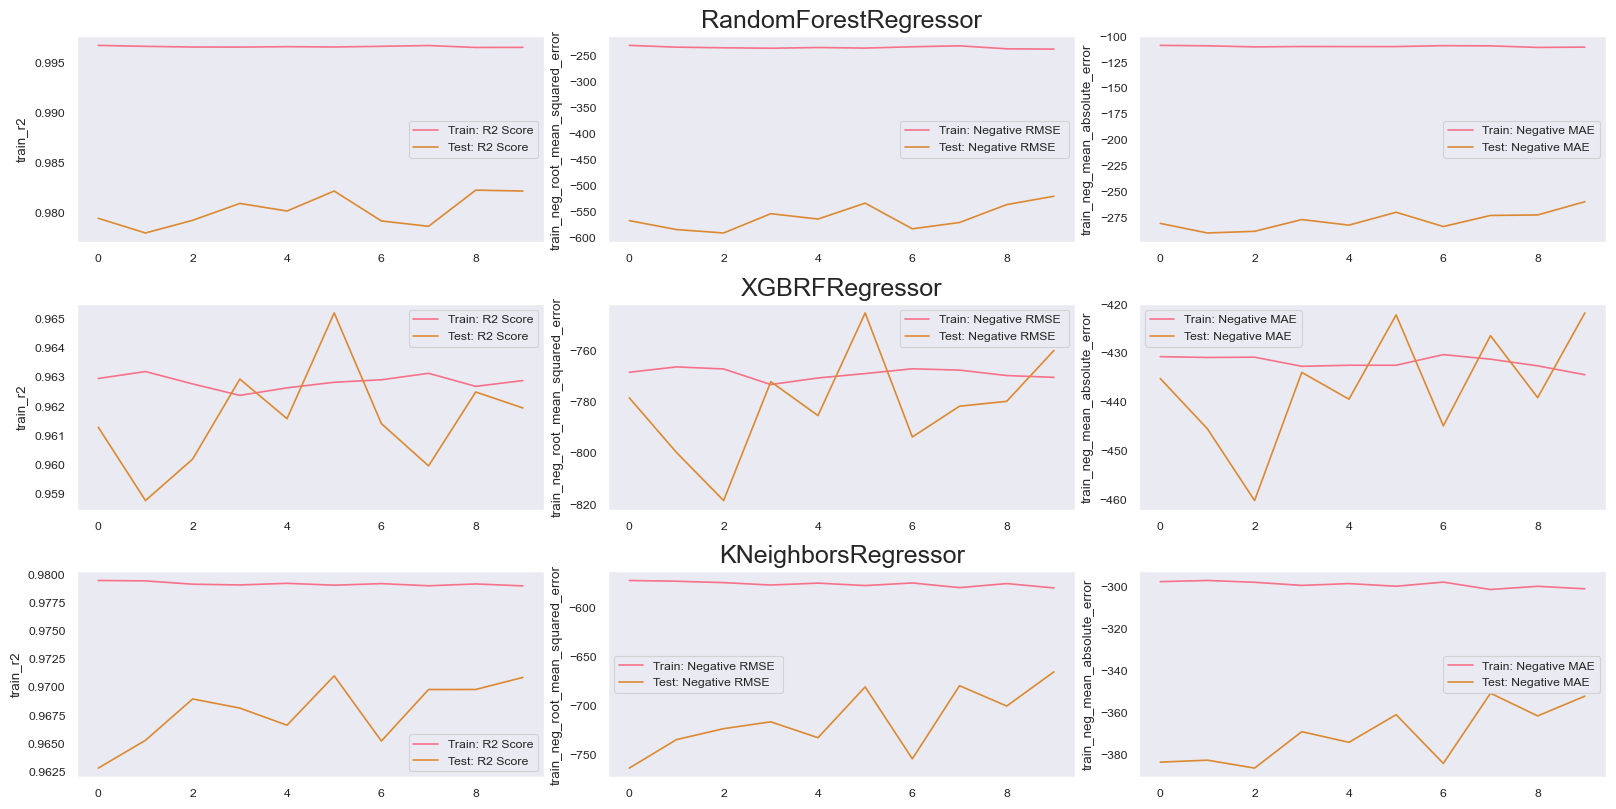

In [ ]:

fig, axes = plt.subplots(nrows = len(models_list), ncols = 3, figsize=(16, 8))
for index, model in enumerate(models_list):

    result = cv_results[cv_results['Model'] == model]

    axes[index, 1].set_title(model, fontsize = 18)

    sns.lineplot(ax=axes[index, 0], data = result['train_r2'], label = 'Train: R2 Score')
    sns.lineplot(ax=axes[index, 0], data = result['test_r2'], label = 'Test: R2 Score')
    
    sns.lineplot(ax=axes[index, 1], data = result['train_neg_root_mean_squared_error'], label = 'Train: Negative RMSE ')
    sns.lineplot(ax=axes[index, 1], data = result['test_neg_root_mean_squared_error'], label = 'Test: Negative RMSE')

    sns.lineplot(ax=axes[index, 2], data = result['train_neg_mean_absolute_error'], label = 'Train: Negative MAE')
    sns.lineplot(ax=axes[index, 2], data = result['test_neg_mean_absolute_error'], label = 'Test: Negative MAE')
plt.legend()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

*   **RandomForestRegressor** exhibits overfitting, performing exceptionally well on training data but showing a drop in performance on test data.
*   **XGBRFRegressor** is less overfitted but has high variance, meaning its performance is inconsistent across different runs.

    To improve generalization, will work on:
*   **Hyperparameter Tuning** (e.g., reducing max depth, increasing regularization).
*   **Feature Engineering** to reduce noise

## HyperParameter Tuning

### Using Optuna

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [44]:
# initialize objectives
objectives = ["R2", "RMSE", "MAE"]

In [45]:
def eval_model(y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return r2, rmse, mae

In [46]:
def plot_history(study):
    fig1 = optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[0], target_name = "R2")
    show(fig1)
    fig2 = optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[1], target_name = "RMSE")
    show(fig2)
    fig3 = optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[2], target_name = "MAE")
    show(fig3)

In [47]:
def plot_hyperparameter_importances(study):
    fig1 = optuna.visualization.plot_param_importances(study, target = lambda t: t.values[0], target_name = "MAE")
    show(fig1)
    fig2 = optuna.visualization.plot_param_importances(study, target = lambda t: t.values[1], target_name = "RMSE")
    show(fig2)
    fig3 = optuna.visualization.plot_param_importances(study, target = lambda t: t.values[2], target_name = "MAE")
    show(fig3)

In [48]:
def find_best_scores(study):
    print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

    trial_with_highest_r2_score = max(study.best_trials, key=lambda t: t.values[0])
    # print("Trial with highest R2_score: ")
    # print(f"\tnumber: {trial_with_highest_r2_score.number}")
    # print(f"\tparams: {trial_with_highest_r2_score.params}")
    # print(f"\tvalues: {trial_with_highest_r2_score.values}")

    trial_with_lowest_rmse = min(study.best_trials, key=lambda t: t.values[1])
    # print("Trial with lowest RMSE: ")
    # print(f"\tnumber: {trial_with_lowest_rmse.number}")
    # print(f"\tparams: {trial_with_lowest_rmse.params}")
    # print(f"\tvalues: {trial_with_lowest_rmse.values}")

    trial_with_lowest_mae = min(study.best_trials, key=lambda t: t.values[2])
    # print("Trial with lowest MAE: ")
    # print(f"\tnumber: {trial_with_lowest_mae.number}")
    # print(f"\tparams: {trial_with_lowest_mae.params}")
    # print(f"\tvalues: {trial_with_lowest_mae.values}")

    return trial_with_highest_r2_score, trial_with_lowest_rmse, trial_with_lowest_mae

In [49]:
# Create an empty DataFrame
best_hyperparam_scores = pd.DataFrame(columns=['Model', 'TrialNumber', 'R2', 'RMSE', 'MAE', 'Params'])

def save_best_hyperparams(model_name, best_hyperparam_scores, trial_with_highest_r2_score, trial_with_lowest_rmse, trial_with_lowest_mae):
    
    best_hyperparams_list = [
        [model_name, 
         trial_with_highest_r2_score.number, 
         trial_with_highest_r2_score.values[0], 
         trial_with_highest_r2_score.values[1], 
         trial_with_highest_r2_score.values[2], 
         trial_with_highest_r2_score.params],
        
        [model_name, 
         trial_with_lowest_rmse.number, 
         trial_with_lowest_rmse.values[0], 
         trial_with_lowest_rmse.values[1], 
         trial_with_lowest_rmse.values[2], 
         trial_with_lowest_rmse.params],
        
        [model_name, 
         trial_with_lowest_mae.number, 
         trial_with_lowest_mae.values[0], 
         trial_with_lowest_mae.values[1], 
         trial_with_lowest_mae.values[2], 
         trial_with_lowest_mae.params]
    ]

    # Convert list to DataFrame
    df_to_add = pd.DataFrame(best_hyperparams_list, columns=best_hyperparam_scores.columns)

    # Use pd.concat() to append rows correctly
    # Check if the DataFrame to add is empty before concatenation
    if not df_to_add.empty:
        best_hyperparam_scores = pd.concat([best_hyperparam_scores, df_to_add], ignore_index=True)
    

    return best_hyperparam_scores  # Return the updated DataFrame

#### Random Forest Algorithm

<font color = '#00008B'>**Note:** While cross_val_score works fine, multi-objective function keeps returning the same value for each trial. \
Since we want to evaluate our model on multple parameters like R2, RMSE and MAE, switching to use train, test split.

In [50]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)

    model = RandomForestRegressor(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf)
    
    #score = cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()

    #return score

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return eval_model(y_test, y_pred)
    
    

In [51]:
# study = optuna.create_study(direction = 'maximize', 
#                             sampler = optuna.samplers.RandomSampler(seed = 42))
study_rf = optuna.create_study(directions = ['maximize', 'minimize', 'minimize'], 
                           sampler = optuna.samplers.RandomSampler(seed = 42))
study_rf.optimize(objective_rf, n_trials = 50)

[I 2025-03-21 21:54:29,792] A new study created in memory with name: no-name-c205fec9-8ba6-4c27-8488-6752e7149d5a
[I 2025-03-21 21:55:29,034] Trial 0 finished with values: [0.9763323042627119, 607.3604921029823, 300.28428460347897] and parameters: {'n_estimators': 437, 'max_depth': 20, 'min_samples_split': 24, 'min_samples_leaf': 20}.
[I 2025-03-21 21:55:42,916] Trial 1 finished with values: [0.9453172036727399, 923.1959850294988, 518.9399396295785] and parameters: {'n_estimators': 240, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 28}.
[I 2025-03-21 21:57:08,729] Trial 2 finished with values: [0.9732326458397241, 645.908904992141, 319.5904326048858] and parameters: {'n_estimators': 641, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 32}.
[I 2025-03-21 21:58:04,158] Trial 3 finished with values: [0.9585017972919923, 804.2354146413259, 447.1644194203949] and parameters: {'n_estimators': 850, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6}.
[I 2

In [52]:
study_rf.best_trials

[FrozenTrial(number=20, state=1, values=[0.9804218490643801, 552.4009104477674, 276.34255495189893], datetime_start=datetime.datetime(2025, 3, 21, 22, 7, 47, 104219), datetime_complete=datetime.datetime(2025, 3, 21, 22, 9, 57, 316909), params={'n_estimators': 877, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=32, log=False, low=1, step=1)}, trial_id=20, value=None),
 FrozenTrial(number=30, state=1, values=[0.9803383897147694, 553.5770683079213, 273.94906662676044], datetime_start=datetime.datetime(2025, 3, 21, 22, 19, 13, 496862), datetime_complete=datetime.datetime(2025, 3, 21, 22, 21, 27, 135351), params={'n_estimators': 827, 'max_depth': 19, 'min_

In [53]:
trial_best_r2, trial_best_rmse, trial_best_mae = find_best_scores(study_rf)
best_hyperparam_scores = save_best_hyperparams("RandomForestRegressor", best_hyperparam_scores, trial_best_r2, trial_best_rmse, trial_best_mae)

best_hyperparam_scores

Number of trials on the Pareto front: 2


/var/folders/s9/jq10pq213hvgwhd8sxxh3lsc0000gn/T/ipykernel_99096/4257354991.py:35: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Model,TrialNumber,R2,RMSE,MAE,Params
0,RandomForestRegressor,20,0.980422,552.400910,276.342555,"{'n_estimators': 877, 'max_depth': 14, 'min_sa..."
1,RandomForestRegressor,20,0.980422,552.400910,276.342555,"{'n_estimators': 877, 'max_depth': 14, 'min_sa..."
2,RandomForestRegressor,30,0.980338,553.577068,273.949067,"{'n_estimators': 827, 'max_depth': 19, 'min_sa..."


In [54]:
optuna.visualization.plot_pareto_front(study_rf, target_names=objectives)

In [55]:
plot_history(study_rf)

In [56]:
plot_hyperparameter_importances(study_rf)

<font color="blue">Running study with 50 trials took 46 minutes identifying two sets as best parameters for achieving max R2 and min RMSE or MAE with max_depth being the most important hyper parameter.

#### XGBoost Algorithm

In [57]:
def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_parallel_tree': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'gamma':trial.suggest_float('gamma', 0.0, 0.4),
        'reg_lambda': trial.suggest_float("reg_lambda", 1, 20),
        'reg_alpha': trial.suggest_float("reg_alpha", 1, 20),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True)
    }

    model = XGBRFRegressor(**param)
    
    #score = cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()

    #return score

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return eval_model(y_test, y_pred)

In [58]:
study_xgb = optuna.create_study(directions = ['maximize', 'minimize', 'minimize'], 
                           sampler = optuna.samplers.RandomSampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 200)

[I 2025-03-21 22:36:10,892] A new study created in memory with name: no-name-8b5c9ea1-8d5e-41f2-acfd-baed766af9e9
[I 2025-03-21 22:36:11,190] Trial 0 finished with values: [0.94677734375, 910.7868041992188, 510.52020263671875] and parameters: {'max_depth': 5, 'n_estimators': 956, 'min_child_weight': 5, 'gamma': 0.23946339367881464, 'reg_lambda': 3.964354168406294, 'reg_alpha': 3.96389588638785, 'eta': 2.9152036385288193e-08}.
[I 2025-03-21 22:36:11,760] Trial 1 finished with values: [0.9541995525360107, 844.8963012695312, 465.4773864746094] and parameters: {'max_depth': 9, 'n_estimators': 641, 'min_child_weight': 5, 'gamma': 0.008233797718320978, 'reg_lambda': 19.428287191077892, 'reg_alpha': 16.816410175208013, 'eta': 4.997040685255803e-07}.
[I 2025-03-21 22:36:12,041] Trial 2 finished with values: [0.9236868619918823, 1090.6068115234375, 612.689697265625] and parameters: {'max_depth': 4, 'n_estimators': 265, 'min_child_weight': 2, 'gamma': 0.20990257265289514, 'reg_lambda': 9.2069553

In [59]:
study_xgb.best_trials

[FrozenTrial(number=171, state=1, values=[0.9732968807220459, 645.1331787109375, 342.3634338378906], datetime_start=datetime.datetime(2025, 3, 21, 22, 37, 42, 936759), datetime_complete=datetime.datetime(2025, 3, 21, 22, 37, 44, 722424), params={'max_depth': 10, 'n_estimators': 775, 'min_child_weight': 1, 'gamma': 0.30330527837160903, 'reg_lambda': 1.4671514127172287, 'reg_alpha': 1.4203474790509478, 'eta': 3.880446973849826e-06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'min_child_weight': IntDistribution(high=6, log=False, low=1, step=1), 'gamma': FloatDistribution(high=0.4, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=20.0, log=False, low=1.0, step=None), 'reg_alpha': FloatDistribution(high=20.0, log=False, low=1.0, step=None), 'eta': FloatDistribution(high=1.0, log=True, low=1e-08, step=None)},

In [60]:
plot_history(study_xgb)

In [61]:
plot_hyperparameter_importances(study_xgb)

<font color="blue">Running study with 200 trials took less than 3 minutes identifying only one set of best parameters for achieving max R2 and min RMSE or MAE with max_depth being the most important hyper parameter.

In [62]:
trial_best_r2, trial_best_rmse, trial_best_mae = find_best_scores(study_xgb)
best_hyperparam_scores = save_best_hyperparams("XGBRFRegressor", best_hyperparam_scores, trial_best_r2, trial_best_rmse, trial_best_mae)

best_hyperparam_scores

Number of trials on the Pareto front: 1


,Model,TrialNumber,R2,RMSE,MAE,Params
0,RandomForestRegressor,20,0.980422,552.400910,276.342555,"{'n_estimators': 877, 'max_depth': 14, 'min_sa..."
1,RandomForestRegressor,20,0.980422,552.400910,276.342555,"{'n_estimators': 877, 'max_depth': 14, 'min_sa..."
2,RandomForestRegressor,30,0.980338,553.577068,273.949067,"{'n_estimators': 827, 'max_depth': 19, 'min_sa..."
3,XGBRFRegressor,171,0.973297,645.133179,342.363434,"{'max_depth': 10, 'n_estimators': 775, 'min_ch..."
4,XGBRFRegressor,171,0.973297,645.133179,342.363434,"{'max_depth': 10, 'n_estimators': 775, 'min_ch..."
5,XGBRFRegressor,171,0.973297,645.133179,342.363434,"{'max_depth': 10, 'n_estimators': 775, 'min_ch..."


#### KNN Algorithm

In [63]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [64]:
def objective_knn(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
    }

    model = KNeighborsRegressor(**param)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    return eval_model(y_test, y_pred)

In [65]:
study_knn = optuna.create_study(directions = ['maximize', 'minimize', 'minimize'], 
                           sampler = optuna.samplers.BruteForceSampler(seed = 42))
study_knn.optimize(objective_knn, n_trials = 25)

/var/folders/s9/jq10pq213hvgwhd8sxxh3lsc0000gn/T/ipykernel_99096/2928584933.py:2: ExperimentalWarning:

BruteForceSampler is experimental (supported from v3.1.0). The interface can change in the future.

[I 2025-03-21 22:38:30,850] A new study created in memory with name: no-name-ef696e4e-f9d2-49bb-b767-7a97dfd46d76
[I 2025-03-21 22:38:32,356] Trial 0 finished with values: [0.9641879830006571, 747.1072321998129, 381.5517055988135] and parameters: {'n_neighbors': 10}.
[I 2025-03-21 22:38:34,583] Trial 1 finished with values: [0.9622395679775783, 767.1619012139884, 388.07393631813125] and parameters: {'n_neighbors': 24}.
[I 2025-03-21 22:38:36,824] Trial 2 finished with values: [0.9630250583399513, 759.1407389049333, 384.4858021258188] and parameters: {'n_neighbors': 18}.
[I 2025-03-21 22:38:38,227] Trial 3 finished with values: [0.9636143090431805, 753.0674263816826, 381.99980224941294] and parameters: {'n_neighbors': 15}.
[I 2025-03-21 22:38:39,367] Trial 4 finished with values: [0.963

In [66]:
study_knn.best_trials

[FrozenTrial(number=13, state=1, values=[0.9646235084455624, 742.5503881110999, 380.92530059854863], datetime_start=datetime.datetime(2025, 3, 21, 22, 38, 53, 454484), datetime_complete=datetime.datetime(2025, 3, 21, 22, 38, 55, 184236), params={'n_neighbors': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=25, log=False, low=1, step=1)}, trial_id=13, value=None),
 FrozenTrial(number=14, state=1, values=[0.9643579957563126, 745.3317266737204, 380.8060344827586], datetime_start=datetime.datetime(2025, 3, 21, 22, 38, 55, 185628), datetime_complete=datetime.datetime(2025, 3, 21, 22, 38, 56, 325796), params={'n_neighbors': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=25, log=False, low=1, step=1)}, trial_id=14, value=None),
 FrozenTrial(number=19, state=1, values=[0.9643223291726923, 745.7045562858801, 380.62739463601537], datetime_start=datetime.datetime(2025, 3

In [67]:
plot_history(study_knn)

<font color="blue">Running study with 25 trials with BruteForceSampler since there is only one hyperparameter, it took less than a minute identifying only two sets of best parameters for achieving max R2 and min RMSE or MAE.

In [68]:
trial_best_r2, trial_best_rmse, trial_best_mae = find_best_scores(study_knn)

best_hyperparam_scores = save_best_hyperparams("KNeighborsRegressor", best_hyperparam_scores, trial_best_r2, trial_best_rmse, trial_best_mae)

best_hyperparam_scores

Number of trials on the Pareto front: 3


,Model,TrialNumber,R2,RMSE,MAE,Params
0,RandomForestRegressor,20,0.980422,552.400910,276.342555,"{'n_estimators': 877, 'max_depth': 14, 'min_sa..."
1,RandomForestRegressor,20,0.980422,552.400910,276.342555,"{'n_estimators': 877, 'max_depth': 14, 'min_sa..."
2,RandomForestRegressor,30,0.980338,553.577068,273.949067,"{'n_estimators': 827, 'max_depth': 19, 'min_sa..."
3,XGBRFRegressor,171,0.973297,645.133179,342.363434,"{'max_depth': 10, 'n_estimators': 775, 'min_ch..."
4,XGBRFRegressor,171,0.973297,645.133179,342.363434,"{'max_depth': 10, 'n_estimators': 775, 'min_ch..."
5,XGBRFRegressor,171,0.973297,645.133179,342.363434,"{'max_depth': 10, 'n_estimators': 775, 'min_ch..."
6,KNeighborsRegressor,13,0.964624,742.550388,380.925301,{'n_neighbors': 7}
7,KNeighborsRegressor,13,0.964624,742.550388,380.925301,{'n_neighbors': 7}
8,KNeighborsRegressor,19,0.964322,745.704556,380.627395,{'n_neighbors': 9}
